In [1]:
# Notebook accompanying Matni and Sarma, ACC 2020 (preprint available at https://arxiv.org/abs/1909.10092)

from slspy import *
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib

In [12]:
class SLS_Obj_RobustL1(SLS_Objective):
    '''
    return max row sum of [C1,D12][R;M]
    '''
    def __init__ (self, epsilon, gamma):
        # to save the objective value
        self._objective_expression = 0
        self._epsilon = epsilon
        self._gamma = gamma
    
    # not yet support output feedback
    def addObjectiveValue(self, sls, objective_value):
        C1  = sls._system_model._C1
        D12 = sls._system_model._D12
        Phi_x = sls._Phi_x
        Phi_u = sls._Phi_u

        matrix = []

        horizon = len(Phi_x)
       
        M = cp.hstack([C1 @ Phi_x[k] + D12 @ Phi_u[k] for k in range(1,horizon)])
        
        m = cp.hstack( [self._epsilon * cp.vstack((Phi_x[k], Phi_u[k])) for k in range(1,horizon)])
        
        self._objective_expression = cp.norm(M, 'inf') + self._gamma * cp.norm(m, 'inf')

        return objective_value + self._objective_expression

In [19]:
def makeSystem(n,p,d,rho=.5,act_dens=1,alpha=.49,d12=5,horizon=10,act_del=0,cSpeed=10):
    # Wrapper function to call SLSpy objects for comparisons with defaults used in paper
    sys = LTI_System (
            Nx = n, Nw = p
        )

    generate_doubly_stochastic_chain (
            system_model = sys,
            rho = rho,
            actuator_density = act_dens,
            alpha = alpha
        )
    generate_BCD_and_zero_initialization(sys)  
    sys._D12 *= d12

    ## d-localized sls

    synthesizer = SLS (
        system_model = sys,
        FIR_horizon = horizon
    )
    synthesizer.resetObjAndCons()


    dlocalized = SLS_Cons_dLocalized (
        act_delay = act_del,
        comm_speed = cSpeed,
        d = d
    )

    synthesizer << dlocalized
    return sys, synthesizer,dlocalized
def make_K_op(Phi_x, Phi_u, n, p, H):
    # Assemble an operator K from the system responses Phi
    K = []
    
    (Ak,Bk,Ck,Dk) = make_state_space_controller0(Phi_x, Phi_u, n, p)
    
    for t in range(H):
        zero_padding = np.zeros((n,p*H-p*(t+1)))
        row = np.hstack((Dk,zero_padding))
        if t>0:
            M = np.hstack([np.matmul(np.matmul(Ck , np.linalg.matrix_power(Ak,t-k-1)) , Bk) for k in range(t)])
            row = np.hstack((M,row))
        if t == 0:
            K = row
        else:
            K = np.vstack((K,row))
    return K

def QRinv(X):
    # QR inverse utility
    q, r = np.linalg.qr(X)
    return np.matmul(np.linalg.inv(r) , q.T)

def closed_loop_l1norm_with_K(Kop,nomA,nomB,nomC,nomD,dA,dB,Z):
    # Compute a closed loop norm for the system
    A = nomA + dA
    B = nomB + dB
    BKop = np.matmul(B , Kop)
    CLinv = bigI - np.matmul(Z , (A + BKop))

    Cl = QRinv(CLinv)
    state_cost = np.matmul(nomC , Cl)
    input_cost = np.matmul(np.matmul(nomD , Kop) , Cl)

    l1norm = np.linalg.norm(np.hstack((state_cost,input_cost)), np.inf)
    res = np.linalg.norm(Cl[-n:,0:n],np.inf)
    return Cl, l1norm, res

def make_state_space_controller0(Phi_x, Phi_u, n, p):
    # Make a state space controller 
    T = len(Phi_x)
    
    # See Theorem 2 of:
    # https://nikolaimatni.github.io/papers/sls_state_space.pdf

    Z = np.diag(np.ones(n*(T-3)), k=-n)
    assert Z.shape == ((T-2)*n, (T-2)*n)

    calI = np.zeros((n*(T-2), n))
    calI[:n, :] = np.eye(n)

    Rhat = np.hstack([Phi_x[k].value for k in range(2, T)])
    Mhat = np.hstack([Phi_u[k].value for k in range(2, T)])
    M1 = Phi_u[1].value
    R1 = Phi_x[1].value

    A = Z - calI.dot(Rhat)
    B = -calI
    C = M1.dot(Rhat) - Mhat
    D = M1
    
    return (A, B, C, D)

In [20]:
# First, set basic params

n = 10 # or 50 for a bigger test
p = 10
T = 10
d = 5 # set to 2 or 5 to reproduce different plots in the paper
eps = .55
gam = 5.58
horizonExtend = 10
H = horizonExtend*T

In [22]:
# Synthesize a robust controller

sys,synthesizer,dlocalized = makeSystem(n,p,d)

synthesizer.setObjOrCons(SLS_Obj_RobustL1(epsilon = eps, gamma = gam))

print('Synthesizing...')
controller = synthesizer.synthesizeControllerModel ()
print('Done.')

dPhix = synthesizer._Phi_x
dPhiu = synthesizer._Phi_u
dKop = make_K_op(dPhix, dPhiu, n, p, H)
Z = np.diag(np.ones(n*(H-1)), k=-n)

I = np.eye(H)
bigI = np.eye(n*H)
nomA = np.kron(I,sys._A)
nomB = np.kron(I,sys._B2)
nomC = np.kron(I,sys._C1)
nomD = np.kron(I,sys._D12)

Synthesizing...
Done.


In [24]:
# Synthesize an optimal controller (epsilon and gamma zero, all else the same)
sys,synthesizer,dlocalized = makeSystem(n,p,d)

synthesizer.setObjOrCons(SLSObj_RobustL1(epsilon = 0, gamma = 0))


print('Synthesizing...')
controller = synthesizer.synthesizeControllerModel ()
print('Done.')

dnomPhix = synthesizer._Phi_x
dnomPhiu = synthesizer._Phi_u
H = horizonExtend*T
Z = np.diag(np.ones(n*(H-1)), k=-n)
dnomKop = make_K_op(dnomPhix, dnomPhiu, n, p, H)
I = np.eye(H)
bigI = np.eye(n*H)
nomA = np.kron(I,sys._A)
nomB = np.kron(I,sys._B2)
nomC = np.kron(I,sys._C1)
nomD = np.kron(I,sys._D12)

Synthesizing...
Done.


In [25]:
I = np.eye(H)
bigI = np.eye(n*H)
nomA = np.kron(I,sys._A)
nomB = np.kron(I,sys._B2)
nomC = np.kron(I,sys._C1)
nomD = np.kron(I,sys._D12)

In [26]:
# Iterate through disturbance matrices with worst-case structure (dA = I, dB = 0)
# As kappa approaches epsilon, the robust controller should reach the robust performance bound.
# The optimal controller cost may exceed the robust performance bound.

kappa_vals = np.linspace(0,eps,num=10)
drobust_norms = []
dnom_norms = []

for kappa in kappa_vals:
    dA = bigI * kappa
    dB = bigI * 0

    M = np.hstack((dA,dB))

    dCl, dl1norm, res0 = closed_loop_l1norm_with_K(dKop,nomA,nomB,nomC,nomD,dA,dB,Z)
    dnomCl, dnoml1norm, res1 = closed_loop_l1norm_with_K(dnomKop,nomA,nomB,nomC,nomD,dA,dB,Z)

    print("Robust closed loop norm: {}, Optimal closed loop norm: {}".format(round(dl1norm,1),round(dnoml1norm,1)))
    
    drobust_norms.append(dl1norm)
    dnom_norms.append(dnoml1norm)


Robust closed loop norm: 2.5, Optimal closed loop norm: 1.4
Robust closed loop norm: 2.7, Optimal closed loop norm: 1.6
Robust closed loop norm: 2.8, Optimal closed loop norm: 1.7
Robust closed loop norm: 3.1, Optimal closed loop norm: 1.9
Robust closed loop norm: 3.3, Optimal closed loop norm: 2.2
Robust closed loop norm: 3.6, Optimal closed loop norm: 2.5
Robust closed loop norm: 3.9, Optimal closed loop norm: 3.0
Robust closed loop norm: 4.4, Optimal closed loop norm: 3.7
Robust closed loop norm: 4.9, Optimal closed loop norm: 4.7
Robust closed loop norm: 5.6, Optimal closed loop norm: 6.7


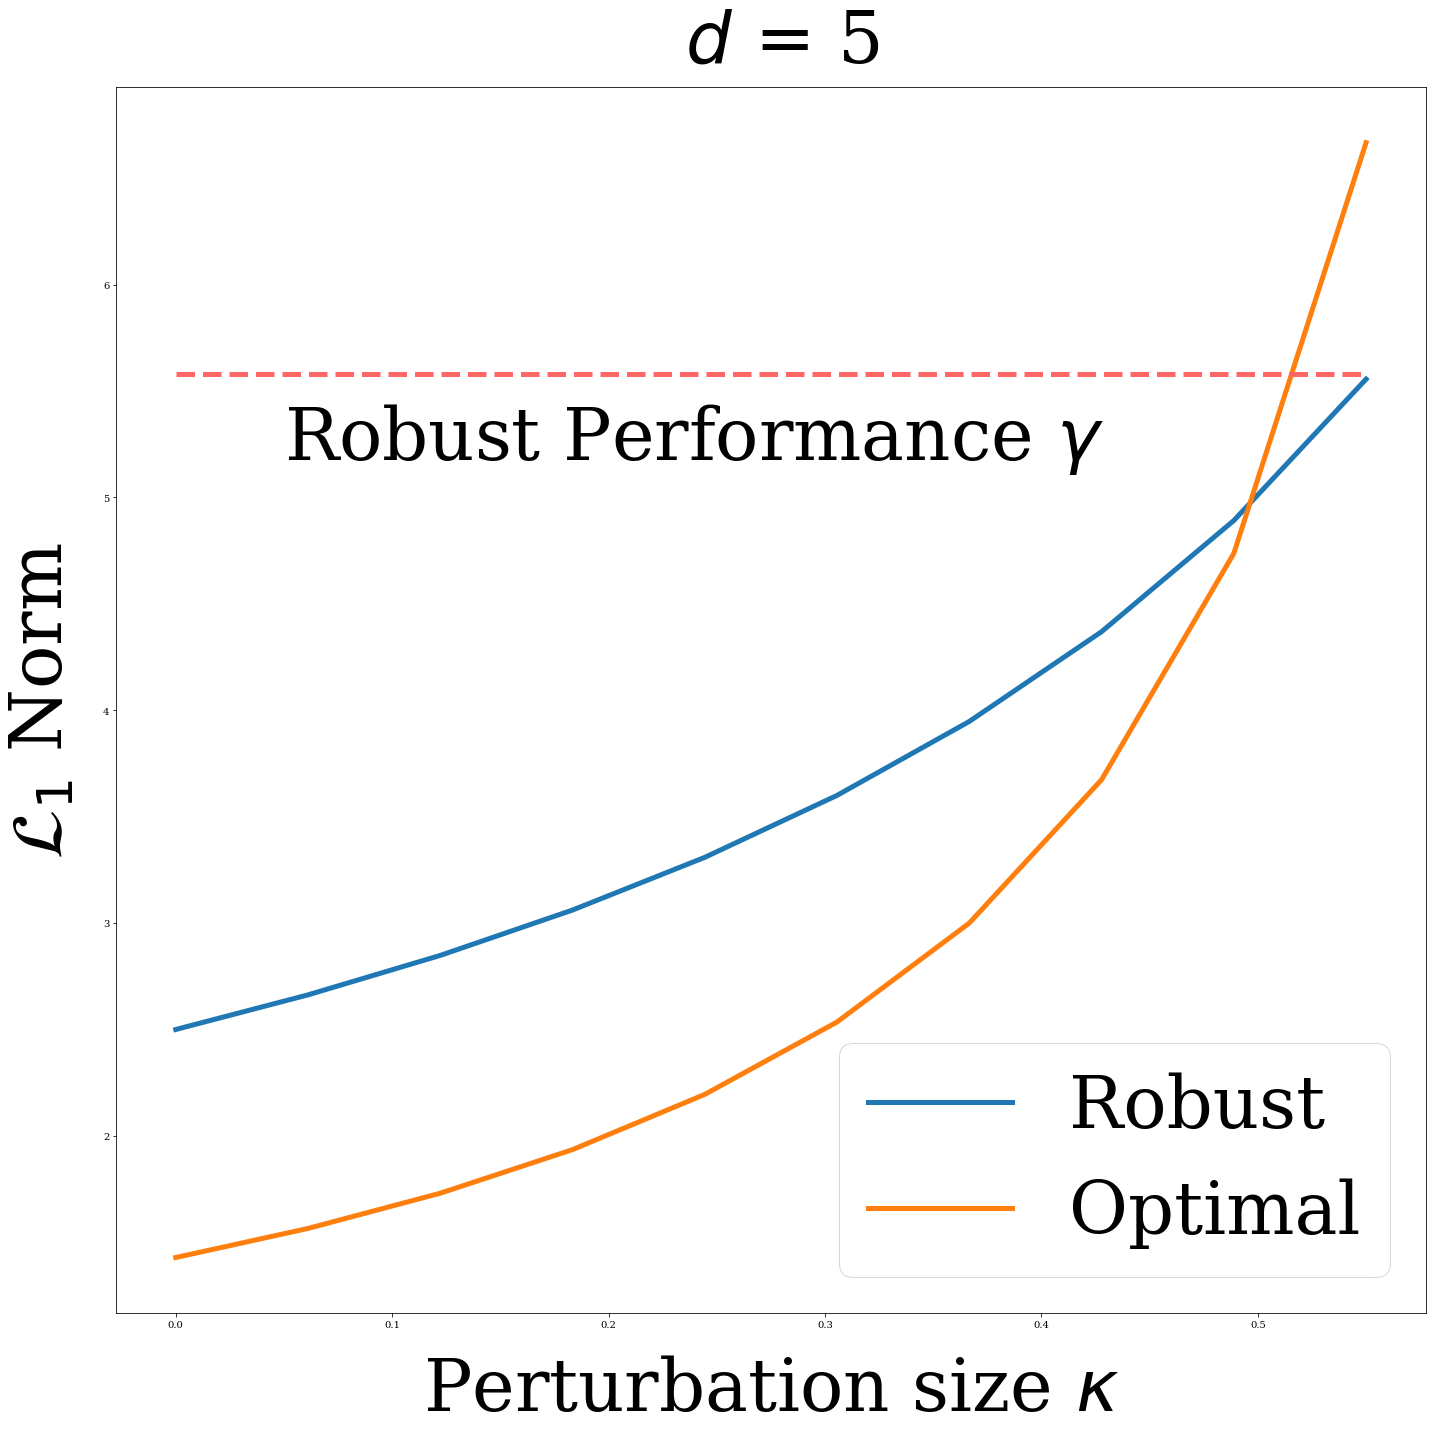

In [27]:
# Create plots comparing robust and optimal for this d

plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')

fs = 72
lw = 5
imsize = 20
lp = 25
plt.figure(figsize=(imsize,imsize))
plt.margins()
plt.rc('xtick', labelsize=fs*.65) 
plt.rc('ytick', labelsize=fs*.65) 
rcParams['axes.titlepad'] = lp 
rcp = {'family': 'sans-serif',
        'weight': 'normal',
        'size': fs,
        }
rcp = {  'size': fs }
plt.plot(kappa_vals, drobust_norms,linewidth = lw)
plt.plot(kappa_vals, dnom_norms,linewidth = lw)
plt.plot(((kappa_vals)),gam*np.ones(len(kappa_vals)),'--',color =(1, .4, .4),linewidth = lw)

if d == 2:
    plt.text(.05,gam-.25,'Robust Performance $\gamma$',fontdict=rcp)
elif d==5:
    plt.text(.05,gam-.4,'Robust Performance $\gamma$',fontdict=rcp)
plt.xlabel(r'Perturbation size $\kappa$', fontsize=fs,labelpad=lp)
plt.ylabel(r'$\mathcal{L}_1$ Norm', fontsize=fs,labelpad=lp)
plt.title(' $d$ = %i'%d,fontsize=fs)
plt.legend(['Robust', 'Optimal'],fontsize = fs,loc='lower right')

plt.tight_layout()
plt.savefig('d%i.png'%d)
plt.show()